# Basic Mixed Hot Water Cylinder

> Simple (fast to run) model of a mixed hot water cylinder

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore.utils import *
import pandas as pd
from cylinder.demand import *
from cylinder.power import *
import matplotlib.pyplot as plt
import random
from collections import deque
import numpy as np

In [ ]:
#export
class HWC():
  """
  Simple mixed model for a hot water cylinder
  """
  # Define constants for clearer code
  def __init__(self,
              element = 3000, # Watts
              T_set = 65, # °C
              T_deadband = 2, # °C
              radius =.25,  # Meters
              height = 1, # Meters
              unit=None,  # Unit of measure for volume
              bedrooms=None,
              rtp = None,
              id = None):
    super(HWC, self).__init__()

    self.T_ambient = 15 #  Air temperature that the cylinder located in °C
    self.T_cold = 15 # Make up water temperature °C
    self.T_demand = 45 #T_demand - temperature of the end use (shower)  °C
    self.T_deadband = T_deadband #T_deadband  - thermostat deadband °C
    self.T_set = T_set #T_set - thermostat set point °C
    self.U = 0.5/60/1000 
    self.Cv = 4.184 
    self.rho = 1000 
    self.Area = 2*np.pi*radius*(radius+height)
    self.Volume = np.pi*radius**2*height
    self.Q = element/1000
    self.thermostat = False
    self.rtp = rtp
    self.id = id


Provide a mechanisim to set the thermostat state based on the model temperature

In [ ]:
@patch
def _thermostat(self:HWC):
    if (self.T < self.T_set- self.T_deadband) :
        self.thermostat = 1
    elif (self.T > self.T_set) :
        self.thermostat = 0
    return

In [ ]:
@patch
def _update_temperatures(self:HWC, action = 1, ts = 60):
    '''
    Use the model from M Jack Paper to update the hwc temperature
    Takes existing state (temperature)
    '''
    temperature = self.T # existing temperatue
    temperature += self.flow/self.Volume*(self.T_cold-self.T) * ts # change in temperature due to flow mixing
    temperature += action * self.thermostat *  self.Q / (self.Cv*self.rho*self.Volume) * ts # change in temperature due to element
    temperature += self.U * self.Area * (self.T_ambient-self.T) * ts # change in temperature due to heat loss
    return temperature


In [ ]:
df = (pd.DataFrame(load_demand(bed=3,unit=3)))
df.columns=["flow"]
df = df.merge(load_power(), how='left', left_index=True, right_index=True)
df.head()

,flow,price,price_kw,date,week,hour,day,peak,tou,cost,n_cost,sr_cost,lr_cost
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,7.920,0.007920,2020-01-01,1,0,2,0,0.02,0.027920,-0.22080,0.162438,0.149272
2020-01-01 00:01:00,0.0,8.526,0.008526,2020-01-01,1,0,2,0,0.02,0.028526,-0.21474,0.158675,0.145694
2020-01-01 00:02:00,0.0,9.132,0.009132,2020-01-01,1,0,2,0,0.02,0.029132,-0.20868,0.155010,0.142235
2020-01-01 00:03:00,0.0,9.738,0.009738,2020-01-01,1,0,2,0,0.02,0.029738,-0.20262,0.151437,0.138888
2020-01-01 00:04:00,0.0,10.344,0.010344,2020-01-01,1,0,2,0,0.02,0.030344,-0.19656,0.147952,0.135645


In [ ]:
hwc = HWC(T_set=68, T_deadband=2, element=3000, radius=.25, height=1)
# set the start temperature to the set temperature with a small random variation
hwc.T = hwc.T_set + np.random.uniform(-4, 0)
hwc.thermostat = 0
thermogram = np.ones([7,24])*(.5+3*.1)

results = []

for index, row in df[:500].iterrows():
  raw_flow = row['flow']
  hwc.flow = raw_flow*(hwc.T_demand-hwc.T_cold)/(hwc.T-hwc.T_cold)
  hwc._thermostat()
  hwc.T = hwc._update_temperatures(action=1)
  results.append([index,hwc.T, hwc.thermostat, hwc.flow,row.cost])
  r,c = row.day, row.hour
  thermogram[r,c] = hwc.thermostat * 1 * hwc.Q /60 + thermogram[r,c]*(1- 0.1)
  # print(hwc.T, hwc.thermostat)
  # hwc.T = hwc._update_temperatures(action = row['power'])
  # df.loc[index,'T'] = hwc.T
results = pd.DataFrame(results, columns=['time','T','thermostat','flow','cost']).set_index('time')

65.87929532569723 1
66.04844901367922 1
66.21743663541636 1
66.38625835394383 1
66.5549143321367 1
66.72340473271018 1
66.89172971821971 1
67.05988945106114 1
67.2278840934709 1
67.39571380752616 1
67.56337875514494 1
67.7308790980863 1
67.89821499795053 1
68.06538661617923 1
68.01328979469382 0
67.9612441191433 0
67.90924953931528 0
67.85730600504664 0
67.80541346622351 0
67.75357187278125 0
67.70178117470432 0
67.65004132202634 0
67.59835226482994 0
67.54671395324678 0
67.49512633745746 0
67.44358936769152 0
67.39210299422732 0
67.34066716739207 0
67.28928183756173 0
67.237946955161 0
67.1866624706632 0
67.13542833459032 0
67.08424449751291 0
67.03311091005006 0
66.98202752286929 0
66.93099428668661 0
66.8800111522664 0
66.82907807042137 0
66.77819499201252 0
66.72736186794906 0
66.67657864918846 0
66.6258452867363 0
66.57516173164623 0
66.52452793502003 0
66.47394384800742 0
66.42340942180611 0
66.37292460766172 0
66.3224893568677 0
66.27210362076536 0
66.22176735074378 0
66.1714804

<matplotlib.image.AxesImage>

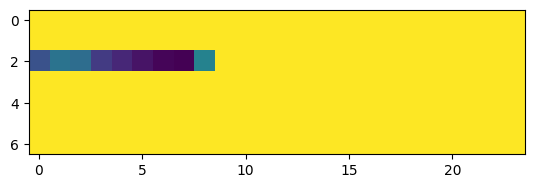

Bad pipe message: %s [b'\x87"\x03s]x\xd3\xcf\xef\x9fu\xfd\xb6\x1b\x81gZ\x18 a*}\x9c9\x9f\x8a\x08\x8f\xf9\x1c\xfa\xa5<\x16\xd2\xab\xd6\xed^w\xa7\x14|\xdc\xb6\x04$T\xb6zM\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x00']
Bad pipe message: %s [b"\xeb\xf9U63\xb2`\x8bxH\xfacG;m\xe3d\xfc\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x00

In [ ]:
plt.imshow(thermogram)

<AxesSubplot: xlabel='time'>

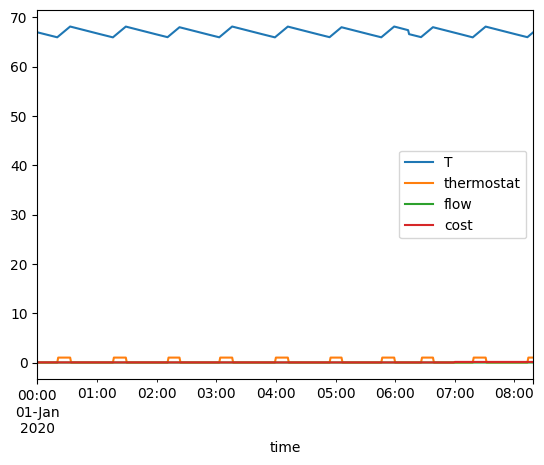

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()